## 0. 混同行列

　モデル予測結果には、「悪性」と「良性」、正解データには「悪性」と「良性」と、それぞれ２パターンがあるので、予測結果と正解データの組み合わせは、全部で４パターンある。４パターンそれぞれの件数を集計し、表の形で整理すると、単に精度（正解率）だけを考えるより意味のある検証ができる。
　「悪性」を「陽性」Positive、つまりモデルで見つけたいことと考えて、置き換えると、混同行列の一般化ができる。予想結果が陽性で正解データも陽性の場合にはTP, 予想結果が陽性で正解データが陰性の場合にはFPと置き換えることによって、一般化した混同行列が得られる。

## １. 設定

In [ ]:
# Do not show warnings
import warnings
warnings.filterwarnings('ignore')

# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib for japanese support
import japanize_matplotlib

# functions for data frame display
from IPython.display import display

# Adjust display options
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.rcParams["font.size"]=14
random_seed = 123

## 2. データの読み込み

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
x = cancer.data
y = 1 - cancer.target
x2 = x[:,:2]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2, y, train_size=0.7, test_size=0.3, random_state=random_seed)

## 3. アルゴリズム選択と評価

In [5]:
from sklearn.linear_model import LogisticRegression
algorithm = LogisticRegression(random_state=random_seed)

algorithm.fit(x_train, y_train)
y_pred = algorithm.predict(x_test)
score = algorithm.score(x_test, y_test)
print(f'score: {score:.4f}')

score: 0.8772


## 4. 混同行列の計算

In [6]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[101   2]
 [ 19  49]]


In [7]:
def make_cm(matrix, columns):
    n = len(columns)
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
    return cm

cm = make_cm(matrix, ['良性', '悪性'])
display(cm)

予測結果    
           良性  悪性
正解データ 良性  101   2
      悪性   19  49

## 5. 精度・適合率・再現率・Ｆ値
「正解数」/「全体件数」= 精度
「全体件数」= TP+TN+FP+FN
「正解数」= TP+TN
「適合率」= TP / (TP + FP) 「陽性」と予測した場合、本当に「陽性」だった割合、陽性の予測結果がどの程度正確かが業務効率に直結するか、営業ターゲットを決める際に有用
「再現率」= TP / (TP + FN) 「陽性」だったデータの内、どの程度をモデルで「陽性」と検知できたかを示す数値。問題のある事象をもれなく洗い出したい場合に使用する。潜在成約顧客の掘り起こし比率を示す。
「F」= 2 *「適合率」* 「再現率」/(「適合率」+「再現率」) F値は、適合率と再現率の中間位になるように計算した値です。この値を最大にするモデルが適合率と再現率をバランスよく最適化しているとみなされる。

In [8]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _= precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'適合率: {precision:.4f}')
print(f'再現率: {recall: .4f}')
print(f'F値: {fscore: .4f}')

適合率: 0.9608
再現率:  0.7206
F値:  0.8235


## 6. 確率値としきい値

In [10]:
y_proba = algorithm.predict_proba(x_test)
print(y_proba[:10,:])

[[0.9925 0.0075]
 [0.9981 0.0019]
 [0.0719 0.9281]
 [0.8134 0.1866]
 [0.0345 0.9655]
 [0.6376 0.3624]
 [0.9694 0.0306]
 [0.9743 0.0257]
 [0.76   0.24  ]
 [0.9775 0.0225]]


In [12]:
y_probal=y_proba[:,1]
print(y_test[10:20])
print(y_pred[10:20])
print(y_probal[10:20])

[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]
[0 1 1 0 1 0 0 0 0 0]
[0 1 0 0 1 0 0 0 0 0]
[0.2111 0.9188 0.1617 0.0609 0.631  0.0549 0.0601 0.0506 0.0383 0.0164]


In [13]:
def pred(algorithm, x, thres):
    y_proba = algorithm.predict_proba(x)
    y_probal = y_proba[:, 1]
    y_pred = (y_probal > thres).astype(int)
    return y_pred

pred_05 = pred(algorithm, x_test, 0.5)
pred_07 = pred(algorithm, x_test, 0.7)

print(pred_05[10:20])
print(pred_07[10:20])

[0 1 0 0 1 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]


## 7. PR曲線
　モデル内の確率値を使ってしきい値を変更させていくと、モデルの適合率と再現率は変化していく。

In [14]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probal)
df_pr = pd.DataFrame([thresholds, precision, recall]).T
df_pr.columns = ['しきい値', '適合率', '再現率']
display(df_pr[52:122:10])

,しきい値,適合率,再現率
52,0.1473,0.7901,0.9412
62,0.2027,0.8310,0.8676
72,0.3371,0.9344,0.8382
82,0.5347,0.9608,0.7206
92,0.7763,0.9756,0.5882
102,0.9025,1.0000,0.4559
112,0.9829,1.0000,0.3088


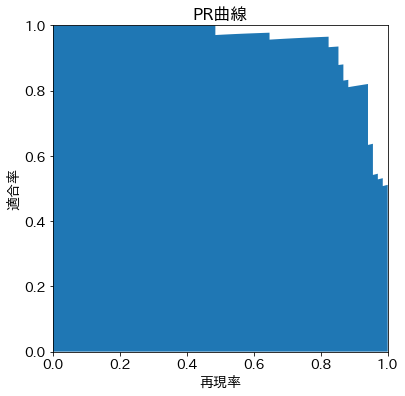

In [15]:
plt.figure(figsize=(6,6))
plt.fill_between(recall, precision, 0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('再現率')
plt.ylabel('適合率')
plt.title('PR曲線')
plt.show()

In [16]:
from sklearn.metrics import auc
pr_auc = auc(recall, precision)
print(f'PR曲線下面積: {pr_auc:.4f}')

PR曲線下面積: 0.9459


## 8. ROC曲線
ＲＯＣ曲線は、「しきい値を変化させた時のモデルの変化をプロットする」という考え方はＰＲ曲線と同じだが、利用する指標値の計算方法が違う。「敏感度」と「偽陽性率」の２つの指標を定義する。敏感度 = TP/(TP + FN)、偽陽性度 = FP/(FP + TN)

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_probal, drop_intermediate=False)

df_roc = pd.DataFrame([thresholds, fpr, tpr]).T
df_roc.columns = ['閾値', '偽陽性率', '敏感度']

display(df_roc[21:91:10])

,閾値,偽陽性率,敏感度
21,0.9829,0.0000,0.3088
31,0.9025,0.0000,0.4559
41,0.7763,0.0097,0.5882
51,0.5347,0.0194,0.7206
61,0.3371,0.0388,0.8382
71,0.2027,0.1165,0.8676
81,0.1473,0.1650,0.9412


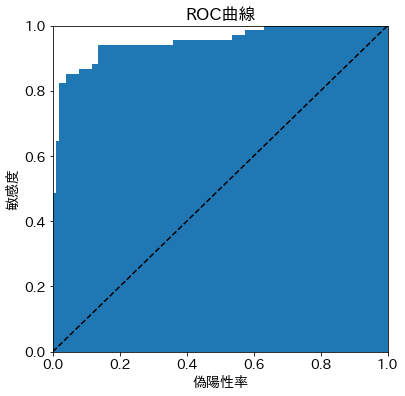

ROC曲線下面積:0.9522


In [18]:
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.fill_between(fpr, tpr, 0)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('偽陽性率')
plt.ylabel('敏感度')
plt.title('ROC曲線')
plt.show()

roc_auc = auc(fpr, tpr)
print(f'ROC曲線下面積:{roc_auc:.4f}')

## 9. 入力項目の重要度

In [22]:
import seaborn as sns
df_iris = sns.load_dataset("iris")
columns_i = ['萼片長', '萼片幅', '花弁長', '花弁幅', '種別']
df_iris.columns = columns_i
x = df_iris[['萼片長', '萼片幅', '花弁長', '花弁幅']]
y = df_iris['種別']

from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=random_seed)

algorithm.fit(x, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [24]:
importances = algorithm.feature_importances_
w = pd.Series(importances, index=x.columns)
u = w.sort_values(ascending=False)
print(u)

花弁長   0.4611
花弁幅   0.4257
萼片長   0.0874
萼片幅   0.0257
dtype: float64


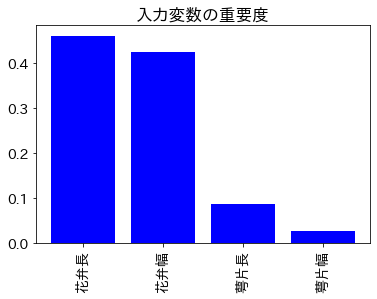

In [26]:
plt.bar(range(len(u)), u, color='b', align='center')
plt.xticks(range(len(u)), u.index, rotation=90)
plt.title('入力変数の重要度')
plt.show()